In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import matplotlib.pyplot as plt
import random
from copy import deepcopy

import statsmodels.api as sm

In [21]:
deltas = []
varss = []

for _ in range(10):
    X = np.linspace(-1, 1, 50).reshape(-1, 1)
    y = np.random.random(50) * 0.9 + 0.1
    kernel = RBF(length_scale=3)
    F = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
    F.fit(X, y)


    grid = np.linspace(-1,1,100).reshape(-1,1)
    X = np.linspace(-1,1,5).reshape(-1,1)
    y = F.predict(X).reshape(-1,1)

    kernel = RBF()
    gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=50)
    gp.fit(X, y)
    for _ in range(20):
        mean,var = gp.predict(grid,return_std = True)
        a = grid[np.argmax(var)]
        a_ = F.predict([a])
    
        deltas.append((a_.item() - mean[np.argmax(var)])**2)
        varss.append(np.max(var))
    
        X = np.append(X,a).reshape(-1,1)
        y = np.append(y,a_).reshape(-1,1)
    
        gp.fit(X, y)

In [27]:
results = sm.OLS(deltas, varss).fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.310
Model:                            OLS   Adj. R-squared (uncentered):              0.306
Method:                 Least Squares   F-statistic:                              89.34
Date:                Thu, 27 Mar 2025   Prob (F-statistic):                    9.49e-18
Time:                        21:35:16   Log-Likelihood:                          6.9033
No. Observations:                 200   AIC:                                     -11.81
Df Residuals:                     199   BIC:                                     -8.508
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

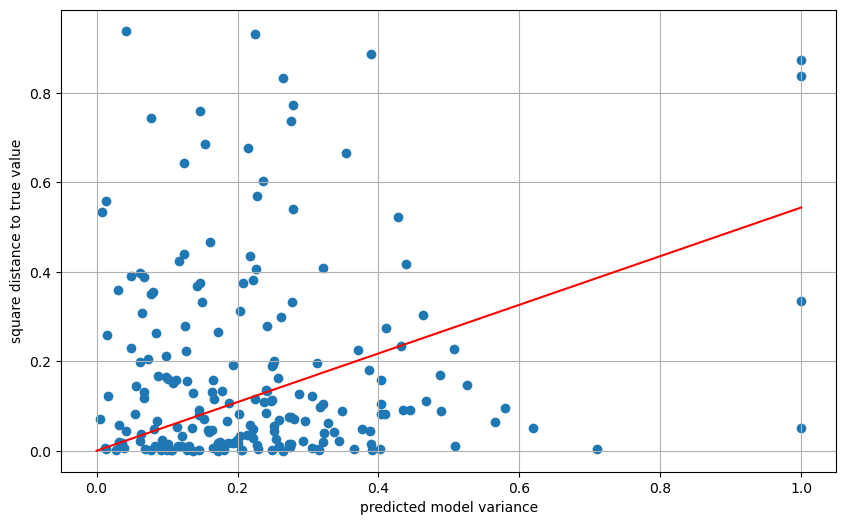

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(varss,deltas)
plt.plot(np.linspace(0, 1, 10),np.linspace(0, 1, 10)*results.params[0],color='red')
plt.xlabel("predicted model variance")
plt.ylabel("square distance to true value")
plt.grid()

Low p-value means that there is statistically significant evidence to reject the null hypothesis. Thus there is a linear dependancy 

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy.stats import qmc
import time

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=16)
        #self.fc2 = nn.Linear(in_features=16, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU()
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        
deltas = []
varss = []

for _ in range(10):
    X = np.linspace(-1, 1, 50).reshape(-1, 1)
    y = np.random.random(50) * 0.9 + 0.1
    kernel = RBF(length_scale=3)
    F = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
    F.fit(X, y)

    
    X_grid = np.linspace(-1,1,100).reshape(-1,1)
    X_train = np.linspace(-1,1,5).reshape(-1,1) 
    y_train = F.predict(X).reshape(-1,1)

    # mse_nn = []
    # r2_nn = []
    # time_nn = []

    mods = []
    
    for _ in range(20):
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        train_losses = []
        val_losses = []

        models = []

        for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            train_data = TensorDataset(torch.Tensor(X_train_fold), torch.Tensor(y_train_fold))
            val_data = TensorDataset(torch.Tensor(X_val_fold), torch.Tensor(y_val_fold))

            batch_size = 16
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

            model = NeuralNet()
            criterion =  nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            num_epochs = 400
            for epoch in range(num_epochs):
                #model.train()
                running_loss = 0.0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                epoch_loss = running_loss / len(train_loader.dataset)
                train_losses.append(epoch_loss)


            models.append(model)

    
        preds = []
        test_preds = []
        grid = torch.Tensor(X_grid)
        

        if True:
            for m in models:
                preds.append(m(grid).detach().numpy())
        
        vars = np.var(preds,axis=0)
        a = X_grid[np.argmax(np.var(preds,axis=0))]
        a_ = F.predict([a])
    
        deltas.append(np.abs(a_.item() - np.mean(preds,axis=0)[np.argmax(var)]))
        varss.append(np.max(vars))

        
        X_train = np.append(X_train,a).reshape(-1,1)
        y_train = np.append(y_train, a_).reshape(-1,1)

        mods = models

In [48]:
results = sm.OLS(deltas, varss).fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.310
Model:                            OLS   Adj. R-squared (uncentered):              0.306
Method:                 Least Squares   F-statistic:                              89.36
Date:                Thu, 27 Mar 2025   Prob (F-statistic):                    9.43e-18
Time:                        21:44:49   Log-Likelihood:                         -9.2160
No. Observations:                 200   AIC:                                      20.43
Df Residuals:                     199   BIC:                                      23.73
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

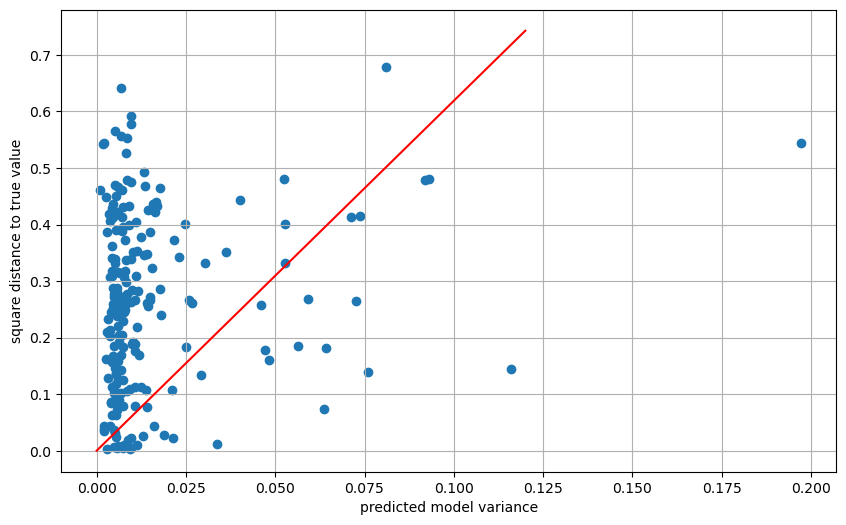

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(varss,deltas)
plt.plot(np.linspace(0, 0.12, 10),np.linspace(0, 0.12, 10)*results.params[0],color='red')
plt.xlabel("predicted model variance")
plt.ylabel("square distance to true value")
plt.grid()